In [119]:
import numpy as np
import skimage.io as sk
import matplotlib as plt
import time
from copy import deepcopy as cp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


gibbsIsing(H, J, betaAll, num_iter, num_neighbors=4)
Вход:  
• H — внешнее магнитное поле, numpy.array, матрица размера vS x hS;  
• J — параметр модели, равен 1 или -1;  
• betaAll — вектор значений параметра β, numpy.array, вектор длины num_beta;  
• num_iter — количество итераций схемы Гиббса;  
• num_neighbors — система соседства, равно 4 или 6;  
Функция должна возвращать словарь с ключами ’E’, ’D’, ’M’, ’S’:  
• E — значения мат.ожиданий энергии на один спин $\frac{1}{N}EE$ для каждой температуры, numpy.array, вектор длины num_beta;  
• D—значения стандартных отклонений энергии на один спин $\frac{1}{N}\sqrt{DE}$ для каждой температуры  
• M — значения средней магнетизации на один спин $\frac{1}{N}Em^2$ для каждой температуры, numpy.array, вектор numpy.array, вектор длины num_beta;  
• S — примеры конфигураций X для всех температур, numpy.array размера vS x hS x num_beta.  

In [68]:
vS = 20
hS = 20

Чтобы обойтись без матрицы смежности будем представлять решетку двумерным массивом (размера $22*22$ c нулевой границей) и считать соседями элементы, граничащие по стороне таблицы в случае прямоугольной системы соседства, и дополнительно соседями на главной диагонали.

In [210]:
def get_start_x():
    x = np.random.binomial(1, 1, (22, 22)) * 2 - 1
    x[0,:] = 0
    x[vS+1,:] = 0
    x[:,0] = 0
    x[:, hS+1] = 0
    return x

In [153]:
def get_betaAll():
#    return [round(1.0 / i, 3) for i in np.arange(0.5, 10, 0.1)]
    return [1.0 / i for i in np.arange(0.5, 10, 0.1)]

In [257]:
def get_neighb_idxes(i, j, num_neighbors=4):
    if (num_neighbors == 4):
        return [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
    if (num_neighbors == 6):
        return [(i-1, j), (i+1, j), (i, j-1), (i, j+1), (i-1, j-1), (i+1, j+1)]

In [246]:
def gibbsIsing(H, J, betaAll, num_iter=10000, num_neighbors=4):
    H = H.flatten()
    start_x = get_start_x()
    x = cp(start_x)
#    queue = np.random.randint(0, vS*hS, num_iter)
    queue = [i % 400 for i in range(num_iter)]
    E = dict()
    m_sum = dict()
    
    # начальные значения m_sum и E
    for beta in betaAll:
        m_sum[beta] = [np.sum(x)]
    
    start_E = H.dot(x[1:21, 1:21].flatten()) 
    for i in range(1, 21):
        for j in range(1, 21):
            neighb = get_neighb_idxes(i, j, num_neighbors)
            for idx in neighb:
                start_E -= 0.5 * J * x[(i,j)]*x[idx]
    for beta in betaAll:
        E[beta] = [start_E]

    # эволюция для каждого beta
    for beta in betaAll:
        x = cp(start_x)
        for x_numb in queue:
            i = x_numb / 20 + 1
            j = x_numb % 20 + 1
            
            neighb = get_neighb_idxes(i, j, num_neighbors)
            cur_E = E[beta][-1]

            delta_Ei = 2*H[x_numb]
            for idx in neighb:
                delta_Ei += 2 * J * x[idx]

            prob = 1.0 / (1 + np.exp(-beta*delta_Ei))
            x_new = np.random.binomial(1, prob, 1) * 2 - 1 

            E[beta].append(0.5*(x[i,j] - x_new)*delta_Ei + cur_E)
            m_sum[beta].append(m_sum[beta][-1] + x_new - x[i,j])
            x[i,j] = x_new
                
    E_mean = [np.mean(E[beta][int(num_iter*0.5):]) / 400.0 for beta in betaAll]
    E_std = [np.std(E[beta][int(num_iter*0.5):]) / 400.0 for beta in betaAll]
    m_mean = [np.mean(np.array(m_sum[beta][int(num_iter*0.5):])**2) / (400.0**2) for beta in betaAll]
    return E_mean, E_std, m_mean

# Ферромагнетик 4

In [258]:
Es = []
Ds = []
Ms = []
for i in range(3):
    E, D, M = gibbsIsing(np.zeros(vS*hS), 1, get_betaAll())
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

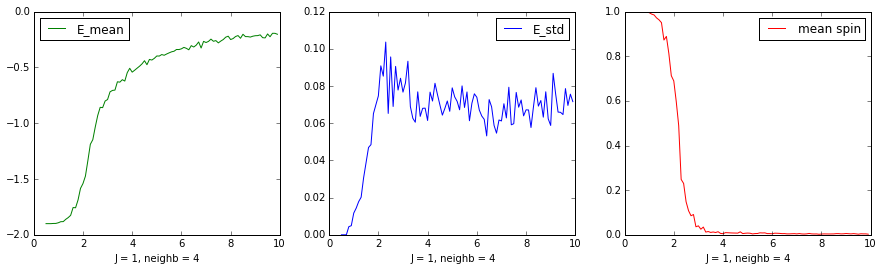

In [259]:
E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("J = 1, neighb = 4")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')

# Антиферромагнетик 4

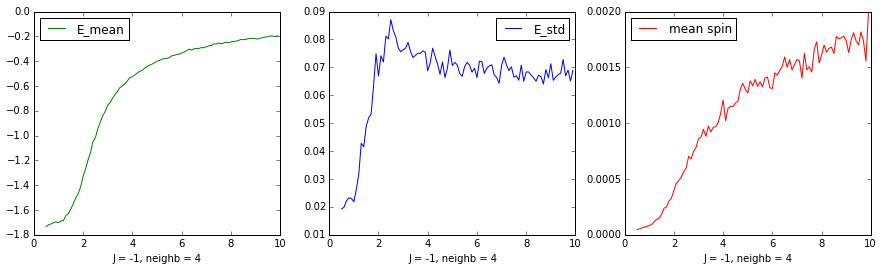

In [252]:
Es = []
Ds = []
Ms = []
for i in range(30):
    E, D, M = gibbsIsing(np.zeros(vS*hS), -1, get_betaAll(), 10000, 4)
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("J = -1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("J = -1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("J = -1, neighb = 4")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')

# Ферромагнетик 6

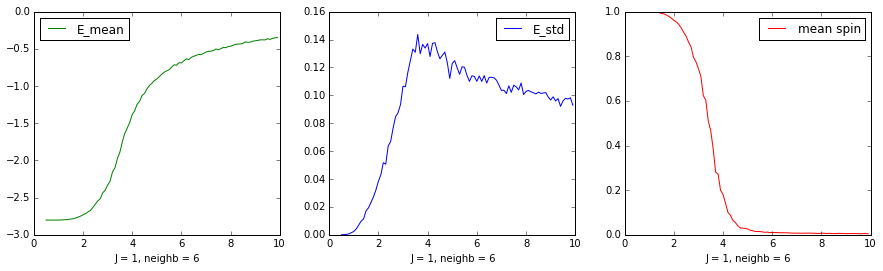

In [262]:
Es = []
Ds = []
Ms = []
for i in range(30):
    E, D, M = gibbsIsing(np.zeros(vS*hS), 1, get_betaAll(), 10000, 6)
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("J = 1, neighb = 6")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("J = 1, neighb = 6")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("J = 1, neighb = 6")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')

# Антиферромагнетик 6

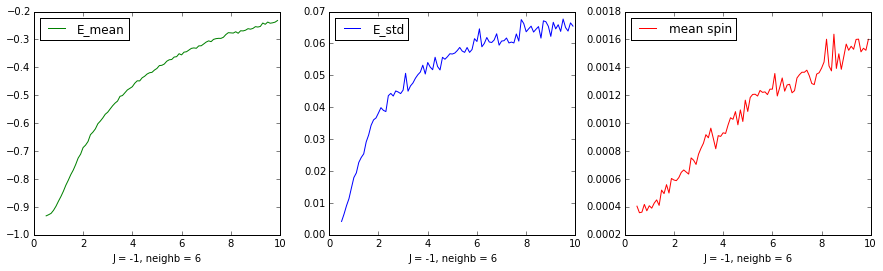

In [263]:
Es = []
Ds = []
Ms = []
for i in range(30):
    E, D, M = gibbsIsing(np.zeros(vS*hS), -1, get_betaAll(), 10000, 6)
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("J = -1, neighb = 6")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("J = -1, neighb = 6")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("J = -1, neighb = 6")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')

# Ферромагнетик 4 поле $H = 1$

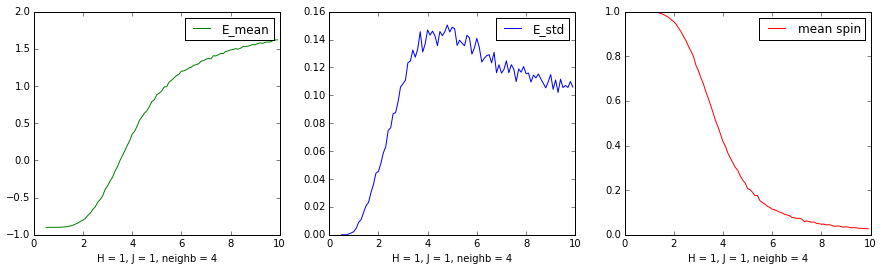

In [264]:
Es = []
Ds = []
Ms = []
for i in range(30):
    E, D, M = gibbsIsing(np.ones(vS*hS), 1, get_betaAll(), 10000, 4)
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("H = 1, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("H = 1, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("H = 1, J = 1, neighb = 4")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')

# Ферромагнетик 4 поле $H = -1$

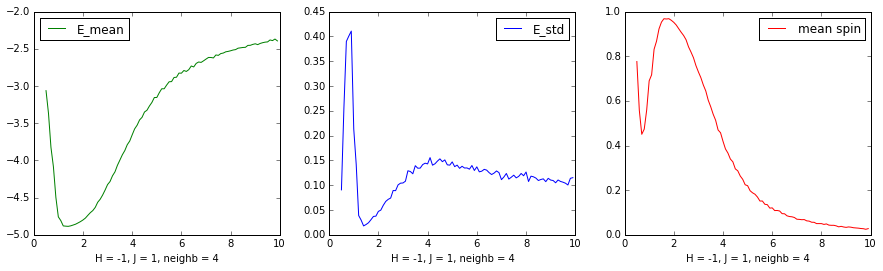

In [265]:
Es = []
Ds = []
Ms = []
for i in range(30):
    E, D, M = gibbsIsing(-np.ones(vS*hS), 1, get_betaAll(), 10000, 4)
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("H = -1, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("H = -1, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("H = -1, J = 1, neighb = 4")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')

# Ферромагнетик 4 поле $H = 3$

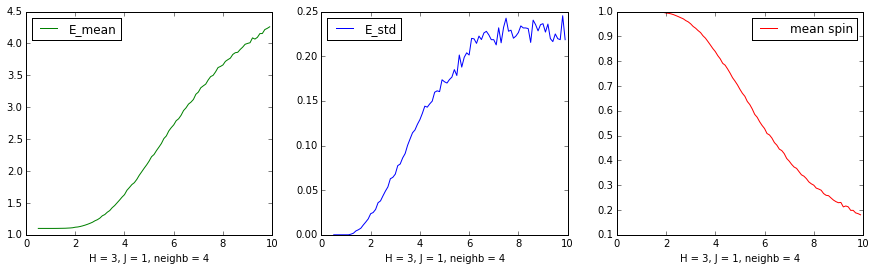

In [266]:
Es = []
Ds = []
Ms = []
for i in range(30):
    E, D, M = gibbsIsing(np.ones(vS*hS) * 3, 1, get_betaAll(), 10000, 4)
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("H = 3, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("H = 3, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("H = 3, J = 1, neighb = 4")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')

# Ферромагнетик 4 поле $H = -3$

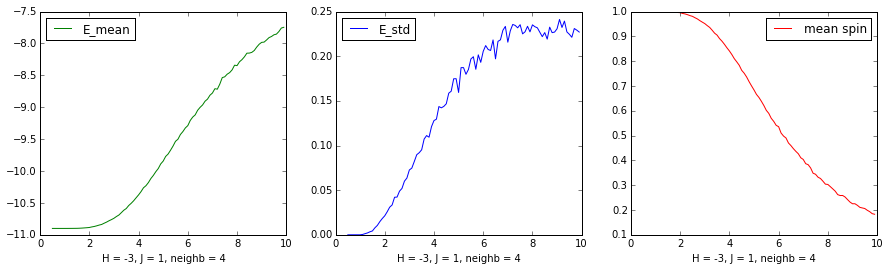

In [267]:
Es = []
Ds = []
Ms = []
for i in range(30):
    E, D, M = gibbsIsing(- np.ones(vS*hS) * 3, 1, get_betaAll(), 10000, 4)
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("H = -3, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("H = -3, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("H = -3, J = 1, neighb = 4")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')

# Ферромагнетик $H$ - половинное

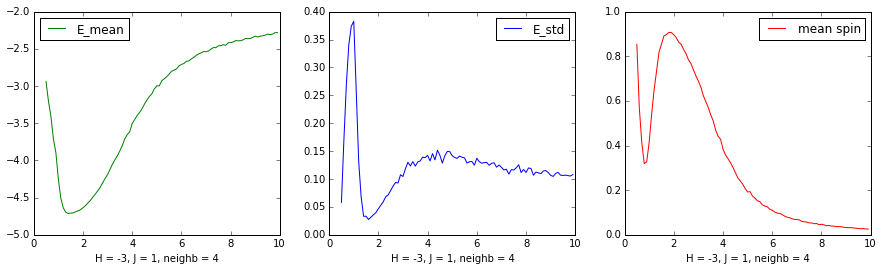

In [268]:
Es = []
Ds = []
Ms = []
H = np.ones(vS*hS)
H[vS / 2:] = -1
for i in range(30):
    E, D, M = gibbsIsing(H, 1, get_betaAll(), 10000, 4)
    Es.append(E)
    Ds.append(D)
    Ms.append(M)

E = np.mean(np.array(Es) ,axis = 0)
D = np.mean(np.array(Ds) ,axis = 0)
M = np.mean(np.array(Ms) ,axis = 0)


fig = plt.figure(figsize = (15, 4))
ax = fig.add_subplot(131)
ax.set_xlabel("H = -3, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), E, color = "green", label = "E_mean")
plt.legend(loc='best')

ax = fig.add_subplot(132)
ax.set_xlabel("H = -3, J = 1, neighb = 4")
ax.plot(np.arange(0.5, 10, 0.1), D, color = "blue", label = "E_std")
plt.legend(loc='best')

ax = fig.add_subplot(133)
ax.set_xlabel("H = -3, J = 1, neighb = 4")
plt.plot(np.arange(0.5, 10, 0.1), M, color = "red", label = "mean spin")
plt.legend(loc='best')